In [7]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cytominer_eval import evaluate_metrics

sys.path.append("..")
from plot_utils import plot_map_x3

from matplotlib import font_manager
font_path = '../../../open-sans/OpenSans-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
bio_map = pd.read_csv("outputs/gcp0004/map_biological.csv.gz")
bio_map

,Metadata_target,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p
0,ABCA1,0.002220,0.513049,0.617086,False,False
1,ABCB1,0.005729,0.364764,0.520217,False,False
2,ABCB11,0.002220,0.513049,0.617086,False,False
3,ABCC8,0.015313,0.299870,0.476843,False,False
4,ABCC9,0.013506,0.092891,0.215898,False,False
...,...,...,...,...,...,...
590,VDR,0.026121,0.048295,0.123329,True,False
591,VKORC1,0.006047,0.338666,0.496125,False,False
592,XDH,0.007092,0.520448,0.619333,False,False
593,XIAP,0.003411,0.431757,0.560907,False,False


In [9]:
bio_map["-log10(mAP p-value)"] = -np.log10(bio_map.corrected_p_value)
bio_map.rename({
    "mean_average_precision": "mAP",
    # "corrected_p_value": "-log10(mAP p-value)",
    # "nlog10qvalue": "-log10(q-value)",
    "below_corrected_p": "p < 0.05",
    # "above_q_threshold": "q < 0.05"
    }, axis=1, inplace=True)
bio_map

,Metadata_target,mAP,p_value,corrected_p_value,below_p,p < 0.05,-log10(mAP p-value)
0,ABCA1,0.002220,0.513049,0.617086,False,False,0.209654
1,ABCB1,0.005729,0.364764,0.520217,False,False,0.283815
2,ABCB11,0.002220,0.513049,0.617086,False,False,0.209654
3,ABCC8,0.015313,0.299870,0.476843,False,False,0.321625
4,ABCC9,0.013506,0.092891,0.215898,False,False,0.665751
...,...,...,...,...,...,...,...
590,VDR,0.026121,0.048295,0.123329,True,False,0.908935
591,VKORC1,0.006047,0.338666,0.496125,False,False,0.304409
592,XDH,0.007092,0.520448,0.619333,False,False,0.208076
593,XIAP,0.003411,0.431757,0.560907,False,False,0.251109


In [4]:
# df = bio_map

# def remove_inner_ticklabels(fig: plt.Figure):
#     """
#     Remove inner ticklabels from a figure.

#     Parameters
#     ----------
#     fig : matplotlib.figure.Figure
#         Figure to remove inner ticklabels from.
#     """
#     for ax in fig.axes:
#         try:
#             ax.label_outer()
#         except AttributeError:
#             pass


# fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

# mean_map = df['mAP'].mean()
# fr = df['q < 0.05'].mean()
# sns.scatterplot(
#     ax=axes[0], 
#     data=df, 
#     x='mAP', 
#     y='-log10(q-value)', 
#     hue='q < 0.05',
#     s=50
# )
# axes[0].set_title("Biological relevance (target genes)")
# axes[0].text(0.75, 0.3, f"FR: {fr:.2f}", transform=axes[0].transAxes)

# axes[0].set_xlabel("")
# axes[0].set_ylim(0, max(df['-log10(q-value)'])+0.1)
# sns.move_legend(axes[0], "upper left")

# # Second Row: KDE plots
# max_kde_y = 0
# mean_map = df['mAP'].mean()
# for p_value in df['q < 0.05'].unique():
#     ax = sns.kdeplot(
#         ax=axes[1],
#         data=df[df['q < 0.05'] == p_value],
#         x='mAP', 
#         label=str(p_value)
#     )
#     max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
#     axes[1].axvline(mean_map, color='grey', linestyle='--')
# # axes[1].set_ylabel("")
# axes[1].set_ylim(0, max_kde_y)
# axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

# for ax in axes.flat:
#     ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

# remove_inner_ticklabels(fig)
# plt.tight_layout()
# plt.show()


In [5]:
# bio_map.drop(columns=["p < 0.05"], inplace=True)
# bio_map.rename(columns={"q < 0.05": "p < 0.05", "-log10(q-value)": "-log10(mAP p-value)"}, inplace=True)
# bio_map["const"] = "cpg0004"
# bio_map

/dgx1nas1/storage/data/akalinin/projects/grit-benchmark/1.calculate-metrics/lincs/../plot_utils.py:105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


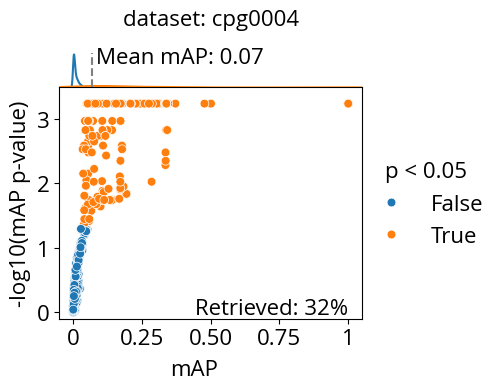

In [10]:
bio_map["const"] = "dataset: cpg0004"
plot_map_x3(bio_map, "const", "", s=40, pr_x=0.45, pr_y=0.02, l_x=1.1, l_y=0.58)